In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from keras.models import Sequential
import seaborn as sns
sns.set_theme(style="whitegrid")

### Reading Dataset

In [53]:
df = pd.read_csv('Gold Price (2013-2023).csv')

In [55]:
df.dropna(inplace=True)

In [57]:
df.rename(columns={'Close': 'Price'}, inplace=True)

In [59]:
df

,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,"1,826.20","1,821.80","1,832.40","1,819.80",107.50K,0.01%
1,12/29/2022,"1,826.00","1,812.30","1,827.30","1,811.20",105.99K,0.56%
2,12/28/2022,"1,815.80","1,822.40","1,822.80","1,804.20",118.08K,-0.40%
3,12/27/2022,"1,823.10","1,808.20","1,841.90","1,808.00",159.62K,0.74%
5,12/23/2022,"1,804.20","1,801.00","1,812.20","1,798.90",105.46K,0.50%
...,...,...,...,...,...,...,...
2578,01/08/2013,"1,663.20","1,651.50","1,662.60","1,648.80",0.13K,0.97%
2579,01/07/2013,"1,647.20","1,657.30","1,663.80","1,645.30",0.09K,-0.16%
2580,01/04/2013,"1,649.90","1,664.40","1,664.40","1,630.00",0.31K,-1.53%
2581,01/03/2013,"1,675.60","1,688.00","1,689.30","1,664.30",0.19K,-0.85%


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2578 entries, 0 to 2582
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      2578 non-null   object
 1   Price     2578 non-null   object
 2   Open      2578 non-null   object
 3   High      2578 non-null   object
 4   Low       2578 non-null   object
 5   Vol.      2578 non-null   object
 6   Change %  2578 non-null   object
dtypes: object(7)
memory usage: 161.1+ KB


In [70]:
df['Price'] = df['Price'].replace({',': ''}, regex=True).astype(float)

### Data preparation

In [73]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

In [75]:
# checking for duplicate
df.duplicated().sum()

0

In [77]:
# checking for missing values 
df.isnull().sum().sum()

0

**Gold price visualization**

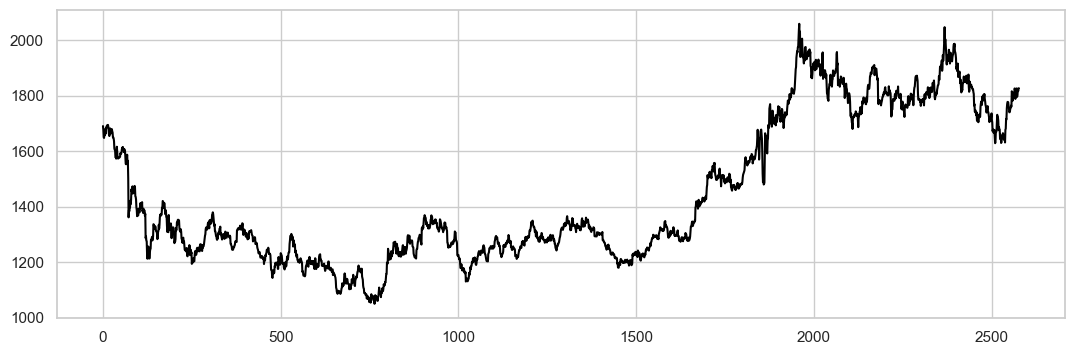

In [80]:
plt.figure(figsize=(13,4))
df['Price'].plot(color='black')
plt.show()

**setting the test size**

In [83]:
# deifne the number of days for test size
test_size = 60
test_size

60

**Gold Price Training and Test Sets Plot**

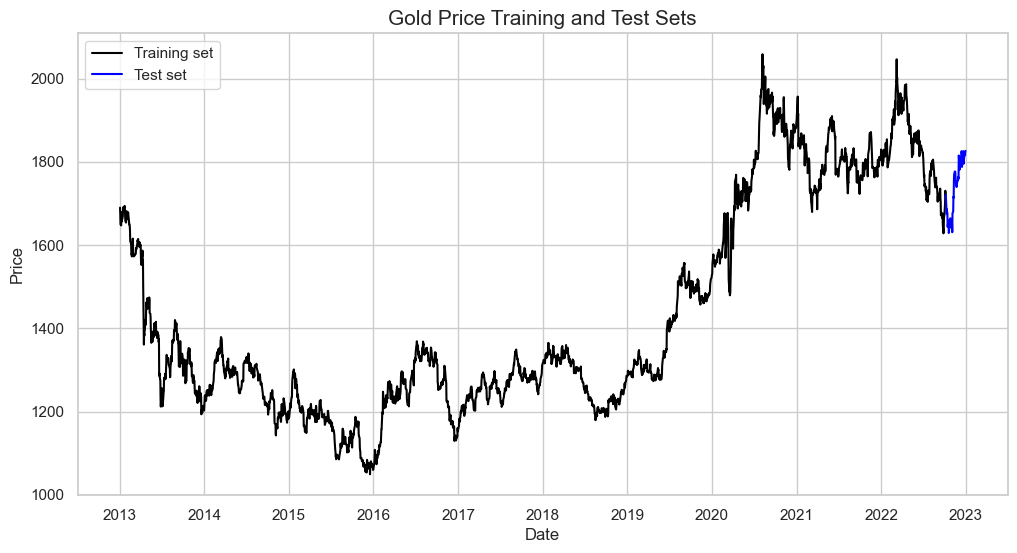

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][:-test_size], df['Price'][:-test_size], color='black')
plt.plot(df['Date'][-test_size:], df['Price'][-test_size:], color='blue')
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left')
plt.show()

In [88]:
# scaling the data
scaler = MinMaxScaler()
scaler.fit(df['Price'].values.reshape(-1,1))

MinMaxScaler()

In [90]:
# Setting window size 
window_size = 60 #(60 days)

**Training Set:**

In [93]:
train_data = df['Price'][:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [95]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

**Testing Set:**

In [98]:
test_data = df['Price'][-test_size-window_size:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [100]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

**Convert the data into acceptable format**

In [103]:
# convert into data format that accepting by the model
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [105]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [107]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (2458, 60, 1)
y_train Shape:  (2458, 1)
X_test Shape:   (60, 60, 1)
y_test Shape:   (60, 1)


**Creating Model**

In [110]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model


**Model training**

In [113]:
import time
import os

t0 = time.time()

# Train model
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=0)

# Calculate runtime
runtime = time.time() - t0
print(f'Time taken to run: {runtime} seconds')
print('\a')

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Time taken to run: 695.6506521701813 seconds



**Evaluate the model**

In [115]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0015
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step


In [116]:
MSE = mean_squared_error(y_test, y_pred)

In [117]:
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.0012514741392806172
Test MSE: 0.0012514740110483513


In [118]:
# Inverse it to the normal scale 
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

In [119]:
MSE = mean_squared_error(y_test_true, y_test_pred)
print("Test Loss:", result)
print("Test MSE:", MSE)

Test Loss: 0.0012514741392806172
Test MSE: 1273.5973562496504


**Investigating the prices predicted with actual**

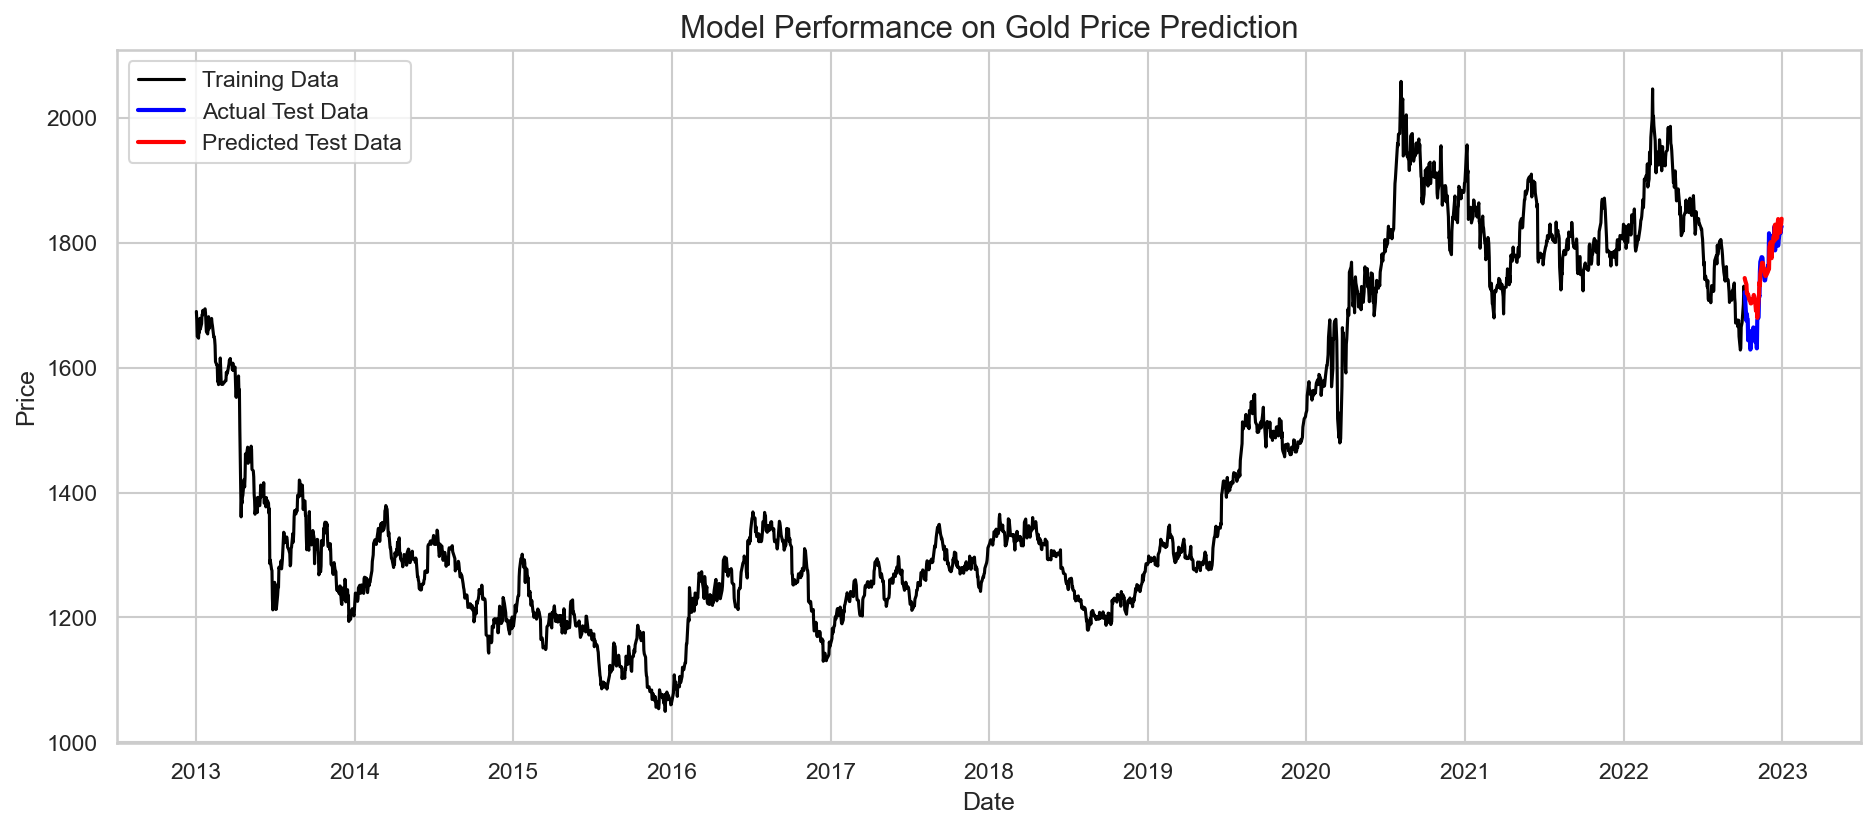

In [121]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black')
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left')
plt.show()